# 패키지

In [2]:
import numpy as np
from tqdm import tqdm
from glob import glob
import os
import pandas as pd
import matplotlib.pylab as plt
import tensorflow as tf
import gc



# 데이터

In [3]:
default_path = './'

In [4]:
train = pd.read_csv(default_path+'data/weekly_train.csv')
test = pd.read_csv(default_path+'data/public_weekly_test.csv')

In [5]:
train.head()

,week_start,week_file_nm,data_list
0,1978-10-23,10000.npy,"19781026.npy,19781028.npy"
1,1978-10-30,10001.npy,"19781030.npy,19781101.npy,19781103.npy,1978110..."
2,1978-11-06,10002.npy,"19781107.npy,19781109.npy,19781111.npy"
3,1978-11-13,10003.npy,"19781113.npy,19781115.npy,19781117.npy,1978111..."
4,1978-11-20,10004.npy,"19781121.npy,19781123.npy,19781125.npy"


In [6]:
test.tail()

,week_start,week_file_nm,data_list
19,2020-05-18,12169.npy,"20200518.npy,20200519.npy,20200520.npy,2020052..."
20,2020-05-25,12170.npy,"20200525.npy,20200526.npy,20200527.npy,2020052..."
21,2020-06-01,12171.npy,"20200601.npy,20200602.npy,20200603.npy,2020060..."
22,2020-06-08,12172.npy,"20200608.npy,20200609.npy,20200610.npy,2020061..."
23,2020-06-15,12173.npy,"20200615.npy,20200616.npy,20200617.npy,2020061..."


# 시각화 & 전처리

최근 약 30년(52주 * 30년) 주별 데이터만을 사용하였습니다.

In [7]:
train_data_path = 'data/weekly_train/'+train.tail(52*30)['week_file_nm'].values

In [8]:
sample = np.load(train_data_path[-1])

각 파일은 해빙 농도(0~250), 북극점(위성 관측 불가 영역), 해안선 마스크, 육지 마스크, 결측값 5개 채널의 배열로 구성되어있습니다.

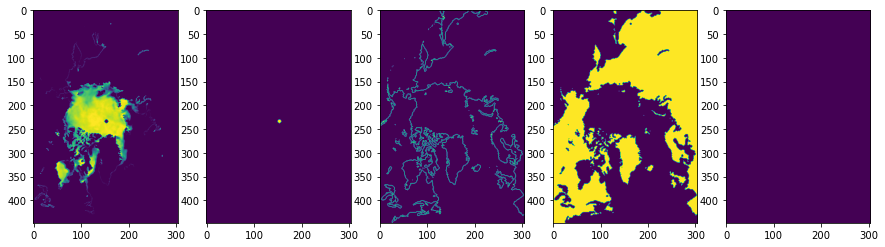

In [9]:
plt.figure(figsize=(15,5))
for c in range(sample.shape[-1]):
    plt.subplot(1,5,c+1)
    plt.imshow(sample[:,:,c])
plt.show()

테스트 활용 가능 마지막 제공 데이터와 맞춰야하는 기간 사이에는 2주의 공백이 있습니다.

과거 12주의 해빙 변화를 보고 2주 뒤부터 12주간 의 변화르 예측하는 모델을 만들겠습니다.

In [10]:
input_window_size = 12
target_window_size = 12
gap = 2
step = 1
input_data_list, target_data_list = [], []

for i in range(0, len(train_data_path)-input_window_size-target_window_size-gap+1, step):
    input_data = train_data_path[i:i+input_window_size]
    target_data = train_data_path[i+input_window_size+gap:i+input_window_size+gap+target_window_size]
    input_data_list.append(input_data)
    target_data_list.append(target_data)

In [11]:
input_data_list[-1]

array(['data/weekly_train/12148.npy', 'data/weekly_train/12149.npy',
       'data/weekly_train/12150.npy', 'data/weekly_train/12151.npy',
       'data/weekly_train/12152.npy', 'data/weekly_train/12153.npy',
       'data/weekly_train/12154.npy', 'data/weekly_train/12155.npy',
       'data/weekly_train/12156.npy', 'data/weekly_train/12157.npy',
       'data/weekly_train/12158.npy', 'data/weekly_train/12159.npy'],
      dtype=object)

In [12]:
target_data_list[-1]

array(['data/weekly_train/12162.npy', 'data/weekly_train/12163.npy',
       'data/weekly_train/12164.npy', 'data/weekly_train/12165.npy',
       'data/weekly_train/12166.npy', 'data/weekly_train/12167.npy',
       'data/weekly_train/12168.npy', 'data/weekly_train/12169.npy',
       'data/weekly_train/12170.npy', 'data/weekly_train/12171.npy',
       'data/weekly_train/12172.npy', 'data/weekly_train/12173.npy'],
      dtype=object)

## 데이터셋

학습과 검증용 데이터로 분리합니다.

최근 1년(52주)을 검증 데이터셋으로 사용하였습니다.

In [13]:
def train_map_func(x_list, y_list):
    train_x, train_y = [], []
    for path in x_list:
        train_x.append(np.load(path)[:,:,0:1])
    for path in y_list:
        train_y.append(np.load(path)[:,:,0:1])
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    
    train_x = train_x.astype(np.float32)/250
    train_y = train_y.astype(np.float32)/250
    return train_x, train_y

In [14]:
BATCH_SIZE = 2

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_data_list[:-52], target_data_list[:-52]))
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(train_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((input_data_list[-52:], target_data_list[-52:]))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(train_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [16]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape, next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([2, 12, 448, 304, 1]),
 TensorShape([2, 12, 448, 304, 1]),
 TensorShape([2, 12, 448, 304, 1]),
 TensorShape([2, 12, 448, 304, 1]))

# 모델

ConvLSTMCell을 이용하여 Seq2Seq모델을 만들었습니다.

## ConvLSTMCell

In [17]:
class ConvLSTMCell(tf.keras.Model):
    def __init__(self, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.kernel_size = kernel_size
        self.bias = bias
        
        self.conv = tf.keras.layers.Conv2D(
            filters = 4 * self.hidden_dim,
            kernel_size = self.kernel_size,
            padding = 'same',
            use_bias = self.bias
        )
        
    def call(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = tf.concat([input_tensor, h_cur], axis=3)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = tf.split(combined_conv, num_or_size_splits=4, axis=-1)
        i = tf.keras.activations.sigmoid(cc_i)
        f = tf.keras.activations.sigmoid(cc_f)
        o = tf.keras.activations.sigmoid(cc_o)
        g = tf.keras.activations.tanh(cc_g)
        
        c_next = f*c_cur+i*g
        h_next = o*tf.keras.activations.tanh(c_next)
        
        return h_next, c_next
        
    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (tf.zeros([batch_size, height, width, self.hidden_dim]),
                tf.zeros([batch_size, height, width, self.hidden_dim]))

## Encoder

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self, hidden, enc_num_layers=1):
        super(Encoder, self).__init__()
        self.enc_num_layers = enc_num_layers
        self.encoder_input_convlstm = ConvLSTMCell(
            hidden_dim=hidden,
            kernel_size=(3, 3),
            bias=True
        )
        if self.enc_num_layers is not None:
            self.hidden_encoder_layers = [
                ConvLSTMCell(
                    hidden_dim=hidden,
                    kernel_size=(3, 3),
                    bias=True
                ) for _ in range(self.enc_num_layers)
            ]
        
    def call(self, enc_input):
        h_t, c_t = self.init_hidden(enc_input, 'seq')
        if self.enc_num_layers is not None:
            hidden_h_t = []
            hidden_c_t = []
            for i in range(self.enc_num_layers):
                hidden_h_t += [self.init_hidden(h_t, i)[0]]
                hidden_c_t += [self.init_hidden(h_t, i)[1]]
        
        seq_len = enc_input.shape[1]
        for t in range(seq_len):
            h_t, c_t = self.encoder_input_convlstm(
                input_tensor=enc_input[:, t, :, :, :],
                cur_state=[h_t, c_t]
            )
            input_tensor = h_t
            if self.enc_num_layers is not None:
                for i in range(self.enc_num_layers):
                    hidden_h_t[i], hidden_c_t[i] = self.hidden_encoder_layers[i](
                        input_tensor=input_tensor,
                        cur_state=[hidden_h_t[i], hidden_c_t[i]]
                    )
                    input_tensor = hidden_h_t[i]
        
        if self.enc_num_layers is not None:
            return hidden_h_t[-1], hidden_c_t[-1]
        else:
            return h_t, c_t
    
    def init_hidden(self, input_tensor, seq):
        if seq == 'seq':
            b, seq_len, h, w, _ = input_tensor.shape
            h_t, c_t = self.encoder_input_convlstm.init_hidden(
                batch_size=b,
                image_size=(h, w)
            )
        else:
            b, h, w, _ = input_tensor.shape
            h_t, c_t = self.hidden_encoder_layers[seq].init_hidden(
                batch_size=b,
                image_size=(h, w)
            )
        return h_t, c_t

In [19]:
sample_enc_input_data = next(iter(train_dataset))[0]
sample_encoder = Encoder(16, 1)
enc_output = sample_encoder(sample_enc_input_data)
enc_output[0].shape, enc_output[1].shape

(TensorShape([2, 448, 304, 16]), TensorShape([2, 448, 304, 16]))

## Decoder

In [20]:
class Decoder(tf.keras.Model):
    def __init__(self, hidden, dec_num_layers=1, future_len=12):
        super(Decoder, self).__init__()
        self.dec_num_layers = dec_num_layers
        self.future_len = future_len
        self.decoder_input_convlstm = ConvLSTMCell(
            hidden_dim=hidden,
            kernel_size=(3, 3),
            bias=True
        )
        if self.dec_num_layers is not None:
            self.hidden_decoder_layers = [
                ConvLSTMCell(
                    hidden_dim=hidden,
                    kernel_size=(3, 3),
                    bias=True
                ) for _ in range(dec_num_layers)
            ]
        
        self.decoder_output_layer = tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=(3,3),
            padding='same',
            activation='sigmoid'
        )
        
    def call(self, enc_output):
        if self.dec_num_layers is not None:
            hidden_h_t = []
            hidden_c_t = []
            for i in range(self.dec_num_layers):
                hidden_h_t += [self.init_hidden(enc_output[0], i)[0]]
                hidden_c_t += [self.init_hidden(enc_output[0], i)[1]]
                
        outputs = []
        input_tensor = enc_output[0]
        h_t, c_t = self.init_hidden(input_tensor, 'seq')
        for t in range(self.future_len):
            h_t, c_t=self.decoder_input_convlstm(
                input_tensor=input_tensor,
                cur_state=[h_t, c_t]
            )
            input_tensor = h_t
            if self.dec_num_layers is not None:
                for i in range(self.dec_num_layers):
                    hidden_h_t[i], hidden_c_t[i] = self.hidden_decoder_layers[i](
                        input_tensor=input_tensor,
                        cur_state=[hidden_h_t[i], hidden_c_t[i]]
                    )
                    input_tensor=hidden_h_t[i]
                output = self.decoder_output_layer(hidden_h_t[-1])
            else:
                output = self.decoder_output_layer(h_t)
            outputs += [output]
        outputs = tf.stack(outputs, 1)
        
        return outputs
    
    def init_hidden(self, input_tensor, seq):
        if seq == 'seq':
            b, h, w, _ = input_tensor.shape
            h_t, c_t = self.decoder_input_convlstm.init_hidden(
                batch_size=b,
                image_size=(h, w)
            )
        else:
            b, h, w, _ = input_tensor.shape
            h_t, c_t = self.hidden_decoder_layers[seq].init_hidden(
                batch_size=b,
                image_size=(h, w)
            )
        return h_t, c_t

In [21]:
sample_decoder = Decoder(16)
dec_output = sample_decoder(enc_output)
dec_output.shape

TensorShape([2, 12, 448, 304, 1])

## Seq2Seq

Encoder와 Decoder를 연결한 최종 모델입니다.

In [22]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, hidden, enc_num_layers=1, dec_num_layers=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(hidden, enc_num_layers)
        self.decoder = Decoder(hidden, dec_num_layers)
        
    def call(self, enc_input):
        enc_output = self.encoder(enc_input)
        dec_output = self.decoder(enc_output)
        
        return dec_output

In [23]:
model = Seq2Seq(16, 1, 1)

## 학습률 & 옵티마이저

In [24]:
learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate)

## 손실 함수

손실함수로 MAE를 사용하였습니다.

In [25]:
@tf.function
def loss_function(output, target):
    mae_loss = tf.math.reduce_mean(tf.keras.losses.MAE(output, target))
    return mae_loss

## 대회 산식(MAE / F1)

검증용으로 사용하였습니다.

In [26]:
def mae_score(true, pred):
    score = np.mean(np.abs(true-pred))
    return score

def f1_score(true, pred):
    target = np.where((true > 0.05) & (true < 0.5))
    
    true = true[target]
    pred = pred[target]
    
    true = np.where(true < 0.15, 0, 1)
    pred = np.where(pred < 0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true + 1e-8)
    recall = right / np.sum(pred + 1e-8)

    score = 2 * precision * recall / (precision + recall + 1e-8)
    
    return score

def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1 + 1e-8)
    
    return score

def val_score(inp, targ):
    output = model(inp)
    score = mae_over_f1(targ.numpy(), output.numpy())
    return score

## 학습 정의

In [27]:
@tf.function
def train_step(inp, targ, training):
    loss = 0
    with tf.GradientTape() as tape:
        output = model(inp)
        for t in range(targ.shape[1]):
            loss += loss_function(targ[:, t], output[:, t])
            
    batch_loss = (loss / int(targ.shape[1]))
    
    if training==True:
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        
    return batch_loss

In [28]:
gc.collect()

14605

## 체크포인트

In [29]:
checkpoint_path = './checkpoint/'
os.makedirs(checkpoint_path, exist_ok=True)
ckpt = tf.train.Checkpoint(
    Seq2Seq=model, 
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [30]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(ckpt_manager.latest_checkpoint)

## 학습

In [ ]:
EPOCHS = 50

loss_plot, val_score_plot = [], []
for epoch in range(EPOCHS):
    total_loss, total_val_score = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataset))
    for (batch, (inp, targ)) in tqdm_dataset:
        batch_loss = train_step(inp, targ, True)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(250*batch_loss.numpy().mean()),
            'Total Loss' : '{:06f}'.format(250*total_loss/(batch+1))
        })
    loss_plot.append(250*total_loss/(batch+1))
    
    tqdm_dataset_val = tqdm(enumerate(val_dataset))
    for (batch, (inp, targ)) in tqdm_dataset_val:
        batch_val_score = val_score(inp, targ)
        total_val_score += batch_val_score.mean()
        
        tqdm_dataset_val.set_postfix({
            'Epoch': epoch + 1,
            'Val Score': '{:06f}'.format(250*batch_val_score.mean()),
            'Val Total_Score' : '{:06f}'.format(250*total_val_score/(batch+1))
        })
    val_score_plot.append(250*total_val_score/(batch+1))
    
    if np.min(val_score_plot) == val_score_plot[-1]:
        ckpt_manager.save()

0it [00:00, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


1it [00:54, 54.60s/it, Epoch=1, Loss=121.352926, Total Loss=121.352928]

## 학습 결과

In [ ]:
plt.plot(loss_plot)
plt.title('loss_plot')
plt.show()

plt.plot(val_score_plot)
plt.title('val_score_plot')
plt.show()

## 모델복원

In [ ]:
ckpt.restore(ckpt_manager.latest_checkpoint)

## 추론

In [ ]:
test = pd.read_csv('data/public_weekly_test.csv')
test_path = './data/weekly_train/'+test.tail(12)['week_file_nm']

In [ ]:
def predict(img_path):
    test_imgs=[]
    for path in img_path:
        test_imgs.append(np.load(path)[:,:,0:1].astype(np.float32)/250)
    test_imgs = np.array([test_imgs])
    enc_input = tf.convert_to_tensor(test_imgs)
    pred = model(enc_input)[0].numpy()*250
    
    return pred

In [ ]:
pred = predict(test_path)

In [ ]:
for i in range(12):
    plt.imshow(pred[i])
    plt.show()

## 제출

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')

In [ ]:
sub_2020 = submission.loc[:11, ['week_start']].copy()
sub_2021 = submission.loc[12:].copy()

sub_2020 = pd.concat([sub_2020, (pd.DataFrame(pred.reshape([12,-1])))], axis=1)
sub_2021.columns = sub_2020.columns
submission = pd.concat([sub_2020, sub_2021])

In [ ]:
submission.to_csv('baseline.csv', index=False)